In [1]:
# to visualize data
import matplotlib.pyplot as plt

# to browse directories
import os

# to manage dataframes
import pandas as pd
import numpy as np

# to calculate the time to run the codes
from datetime import datetime

# the deep learning framework (TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0,DenseNet121,MobileNetV2,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Disable GPU

In [ ]:
tf.config.set_visible_devices([], 'GPU')

# Read Dataset

### Keras Image Dataset

In [3]:
DATASET_PATH = "data/birds-20"

image_size = (224, 224)
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH,"train"),
    validation_split=0.2,
    label_mode = "categorical",
    subset="training",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH,"train"),
    validation_split=0.2,
    label_mode = "categorical",
    subset="validation",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)


Found 3208 files belonging to 20 classes.
Using 2567 files for training.
Found 3208 files belonging to 20 classes.
Using 641 files for validation.


In [5]:
train_ds.class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL']

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)


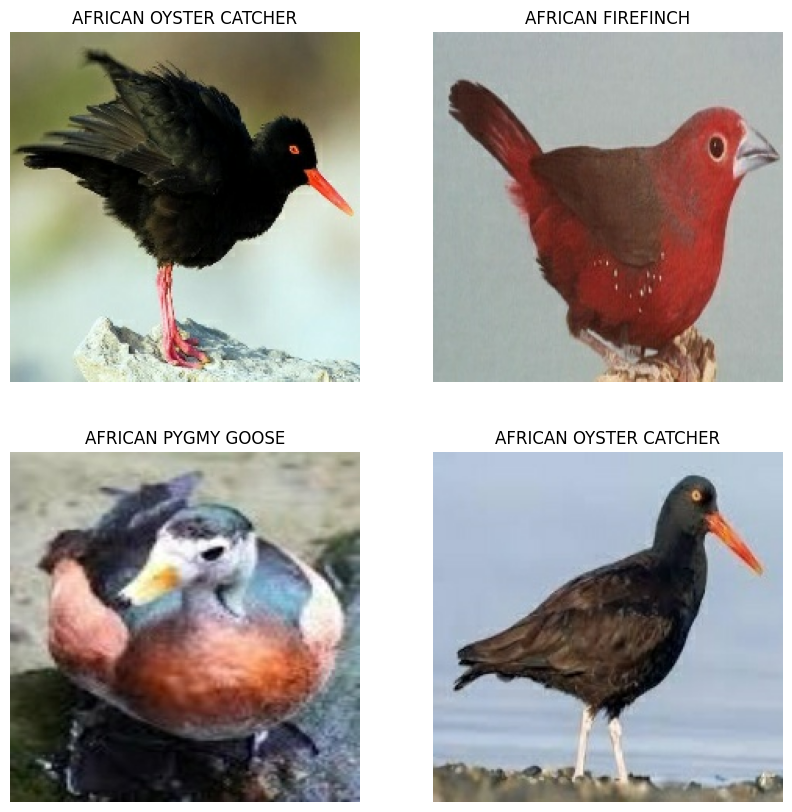

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): 
    for i in range(len(images)):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(labels[i])
        plt.title(train_ds.class_names[int(np.argmax(labels[i].numpy()).astype("uint8"))])
        plt.axis("off")
    

### ImageDataGenerator

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
)  

# No need to augment validation data
datagen_valid = ImageDataGenerator(samplewise_center=True)

In [33]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    "data/birds-20/train",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
)

# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    "data/birds-20/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=8,
)

Found 3208 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


In [35]:
for image,labels in train_it:
    print(image,labels)
    break

[[[[  44.92428      40.92428      -6.0757217 ]
   [  45.226524     41.226524     -5.7734756 ]
   [  45.52877      41.52877      -5.4712296 ]
   ...
   [  -9.26947     -11.9067      -34.722717  ]
   [  -6.3726044   -11.177498    -33.76282   ]
   [  -3.5381546    -7.5381546   -32.538155  ]]

  [[  47.128197     43.12819      -3.871811  ]
   [  47.32969      43.32969      -3.670311  ]
   [  47.53118      43.53119      -3.468811  ]
   ...
   [  -9.148453    -11.65889     -34.488743  ]
   [  -4.8513565    -9.755371    -32.043335  ]
   [  -1.9376373    -5.9376373   -30.937637  ]]

  [[  48.949913     44.949913     -2.050087  ]
   [  49.151405     45.151405     -1.8485947 ]
   [  49.352913     45.352913     -1.6470947 ]
   ...
   [  -9.5739975   -11.7369995   -34.8162    ]
   [  -4.9447784    -9.132149    -33.545     ]
   [  -2.9974365    -7.0046616   -31.982986  ]]

  ...

  [[  58.729713     41.40029      -2.6820679 ]
   [  57.960503     41.015686     -3.0027084 ]
   [  57.35601      40.713

In [163]:
train_it.classes

array([ 0,  0,  0, ..., 19, 19, 19])

# Prepare The Output Directory

In [7]:
outputs_dir = "Notebook Outputs/"

import time
now = time.strftime("%m-%d_%H-%M", time.localtime())

model_name = now+"_keras_cnn"
model_save_dir = outputs_dir+model_name+"/models/"
log_save_dir = outputs_dir+model_name+"/logs/"
res_data_dir = outputs_dir+model_name+"/results/"

os.makedirs(outputs_dir,exist_ok=True)
os.makedirs(model_save_dir,exist_ok=True)
os.makedirs(log_save_dir,exist_ok=True)
os.makedirs(res_data_dir,exist_ok=True)

In [8]:
def create_model(model_name):
    return ModelCheckpoint(
        model_save_dir+model_name+".h5", 
        verbose = 1, 
        monitor = 'val_loss',
        include_optimizer=False,
        # save_best_only = True, 
        mode = 'auto'
    )

def create_csv_logger(model_name):
    return CSVLogger(log_save_dir+'{}-log.csv'.format(model_name), append=True, separator=',')

class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.Inf
        self.best_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')
        loss=logs.get('loss')

        # If BOTH the validation loss AND map10 does not improve for 'patience' epochs, stop training early.
        if np.less(v_loss, self.best_v_loss) and np.less(loss, self.best_loss):
            self.best_v_loss = v_loss
            self.best_loss = loss
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
            model.save(model_save_dir+model_name[0:10]+".h5",include_optimizer=False)

        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                model.save(model_save_dir+model_name[0:10]+".h5",include_optimizer=False)
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
        print("Restoring model weights from the end of the best epoch.")
        self.model.set_weights(self.best_weights)

class TimedStopping(tf.keras.callbacks.Callback):
    '''Stop training when enough time has passed.
    # Arguments
        seconds: maximum time before stopping.
        verbose: verbosity mode.
    '''
    def __init__(self, seconds=None, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()

        self.start_time = 0
        self.seconds = seconds
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_batch_end(self, epoch, logs={}):
        if time.time() - self.start_time > self.seconds:
            self.model.stop_training = True
            if self.verbose:
                print('Stopping after %s seconds.' % self.seconds)

### Own Model

In [19]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense, GlobalAveragePooling2D

# the input layer
inputs = tf.keras.layers.Input(shape=(224,224,3))

# the feature extractor
base_model = Conv2D(filters=32,kernel_size=(3,3),strides=1,padding='same',activation='relu')(inputs)
base_model = MaxPool2D(pool_size=(2,2),strides=1)(base_model)

base_model = Conv2D(filters=64,kernel_size=(5,5),strides=1,padding='same')(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=1)(base_model)

base_model = Conv2D(filters=128,kernel_size=(7,7),strides=1,padding='same',activation='relu')(base_model)
base_model = MaxPool2D(pool_size=(2,2),strides=1)(base_model)

# base_model = Conv2D(filters=256,kernel_size=(5,5),strides=1,padding='same',activation='relu')(base_model)
# base_model = MaxPool2D(pool_size=(2,2),strides=1)(base_model)

# pool the feature maps to reduce the dimensions
# X = Flatten()(base_model)
X = GlobalAveragePooling2D()(base_model)

# the output layers with 2 neurons which represents the 2 output classes
X = Dense(32,activation='relu')(X)
outputs = Dense(len(train_ds.class_names),activation='softmax')(X)
model = Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 223, 223, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 223, 223, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 222, 222, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 128)     401536

In [9]:
# the input layer
inputs = tf.keras.layers.Input(shape=(224,224,3))

# the feature extractor
base_model = EfficientNetB0(weights='imagenet',input_shape=(224,224,3),include_top=False)(inputs)
# set the weights untrainable for transfer learning
base_model.trainable = False

# pool the feature maps to reduce the dimensions
X = layers.GlobalAveragePooling2D()(base_model)

# the output layers with 2 neurons which represents the 2 output classes
outputs = layers.Dense(len(train_ds.class_names),activation='softmax')(X)
model = Model(inputs,outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 4,075,191
Trainable params: 4,033,168
Non-trainable params: 42,023
_________________________________________________________________


In [10]:
model.get_layer('efficientnetb0').summary()


Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [13]:
model.trainable=True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 4,075,191
Trainable params: 4,033,168
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
model.get_layer('efficientnetb0').summary()

In [14]:
def freeze_weights(model,backbone_name:str,unfrozen_blocks:list):
    # model.trainable=True

    layer_names = model.get_layer(backbone_name).layers
    for i in range(len(layer_names)):
        exist_flag = False
        for j in unfrozen_blocks:
            if j not in model.get_layer(backbone_name).layers[i].name and not exist_flag:
                model.get_layer(backbone_name).layers[i].trainable = False
            else:
                model.get_layer(backbone_name).layers[i].trainable = True
                exist_flag = True
            
    return model


In [16]:
model = freeze_weights(model,backbone_name='efficientnetb0',unfrozen_blocks = ['block6','block7'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                25620     
                                                                 
Total params: 4,075,191
Trainable params: 2,769,200
Non-trainable params: 1,305,991
_________________________________________________________________


In [29]:
model.layers[1].trainable=False
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 20)                25620     
                                                                 
Total params: 4,075,191
Trainable params: 25,620
Non-trainable params: 4,049,571
_________________________________________________________________


In [17]:
regularizer = tf.keras.regularizers.l2(0.1)

for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

In [20]:
opt = Adam(learning_rate = 1e-3)
model.compile(
    optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
)

In [21]:
epochs = 10
callback_fn = [create_model(model_name),create_csv_logger(model_name),CustomEarlyStopping(patience = 5)
            #    ,TimedStopping(seconds=900, verbose=1)
               ]

timestamp1 = datetime.now()
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = callback_fn, verbose=1)
timestamp2 = datetime.now()

print("The training took {} seconds".format((timestamp2 - timestamp1).total_seconds()))


Epoch 1/10


642/642 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.8294
Epoch 1: saving model to Notebook Outputs/03-20_20-26_keras_cnn/models\03-20_20-26_keras_cnn.h5
642/642 [==============================] - 89s 96ms/step - loss: 0.5965 - accuracy: 0.8294 - val_loss: 0.1710 - val_accuracy: 0.9470
Epoch 2/10
642/642 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9466
Epoch 2: saving model to Notebook Outputs/03-20_20-26_keras_cnn/models\03-20_20-26_keras_cnn.h5
642/642 [==============================] - 50s 78ms/step - loss: 0.1719 - accuracy: 0.9466 - val_loss: 0.2966 - val_accuracy: 0.9298
Epoch 3/10
641/642 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9657
Epoch 3: saving model to Notebook Outputs/03-20_20-26_keras_cnn/models\03-20_20-26_keras_cnn.h5
642/642 [==============================] - 55s 86ms/step - loss: 0.1111 - accuracy: 0.9657 - val_loss: 0.3415 - val_accuracy: 0.9111
Epoch 4/10
642/642 [================

In [164]:
epochs = 10
callback_fn = [create_model(model_name),create_csv_logger(model_name),CustomEarlyStopping(patience = 10)
            #    ,TimedStopping(seconds=900, verbose=1)
               ]

timestamp1 = datetime.now()
hist = model.fit(train_it, epochs=epochs, validation_data=valid_it, callbacks = callback_fn, verbose=1)
timestamp2 = datetime.now()

print("The training took {} seconds".format((timestamp2 - timestamp1).total_seconds()))


Epoch 1/10
401/401 [==============================] - ETA: 0s - loss: 0.3367 - accuracy: 0.8984
Epoch 1: saving model to Notebook Outputs/03-20_18-14_keras_cnn/models\03-20_18-14_keras_cnn.h5
401/401 [==============================] - 54s 117ms/step - loss: 0.3367 - accuracy: 0.8984 - val_loss: 0.4479 - val_accuracy: 0.9400
Epoch 2/10
401/401 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9483
Epoch 2: saving model to Notebook Outputs/03-20_18-14_keras_cnn/models\03-20_18-14_keras_cnn.h5
401/401 [==============================] - 39s 96ms/step - loss: 0.1630 - accuracy: 0.9483 - val_loss: 0.0754 - val_accuracy: 0.9800
Epoch 3/10
401/401 [==============================] - ETA: 0s - loss: 0.1112 - accuracy: 0.9617
Epoch 3: saving model to Notebook Outputs/03-20_18-14_keras_cnn/models\03-20_18-14_keras_cnn.h5
401/401 [==============================] - 46s 115ms/step - loss: 0.1112 - accuracy: 0.9617 - val_loss: 0.0871 - val_accuracy: 0.9700
Epoch 4/10
401/401 [===

KeyboardInterrupt: 

In [22]:
acc = hist.history['accuracy']
loss = hist.history['loss']
val_accuracy = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
epochs = range(0, len(loss))

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training and validation Loss".format())
plt.legend()
plt.savefig(res_data_dir + "Loss.png".format(model_name), dpi=100)
plt.close()

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label="Validation Accuracy")
plt.title("Training and validation Accuracy".format())
plt.legend()
plt.savefig(res_data_dir + "Accuracy.png".format(model_name), dpi=100)
plt.close()

avg_train_acc = np.mean(acc)
avg_train_loss = np.mean(loss)         
avg_val_acc = np.mean(val_accuracy)
avg_val_loss = np.mean(val_loss)

with open(res_data_dir+'Train Results.txt', 'a') as files:
    files.write("Average Train Accuracy : {} \n".format(avg_train_acc))
    files.write("Average Train Loss : {} \n".format(avg_train_loss))
    files.write("Average Validation Accuracy : {} \n".format(avg_val_acc))
    files.write("Average Validation Loss : {} \n".format(avg_val_loss))

model.save(model_save_dir+model_name[0:10]+".h5")

In [26]:
def test_model(model,test_data):
    y = []
    y_preds = []
    for images,labels in test_data:
        y_pred = model.predict(images)
        y.append(labels[0].numpy())
        y_preds.append(y_pred[0])

    cm = confusion_matrix(y_true=np.argmax(y,axis=1),y_pred=np.argmax(y_preds,axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # auc = roc_auc_score(y_true = np.argmax(y,axis=1),y_score=np.array(y_preds)[:,1])
    # print(auc)
    return y_preds,y

In [23]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH,"test"),
    validation_split=None,
    label_mode = "categorical",
    # subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=1,
)

Found 100 files belonging to 20 classes.


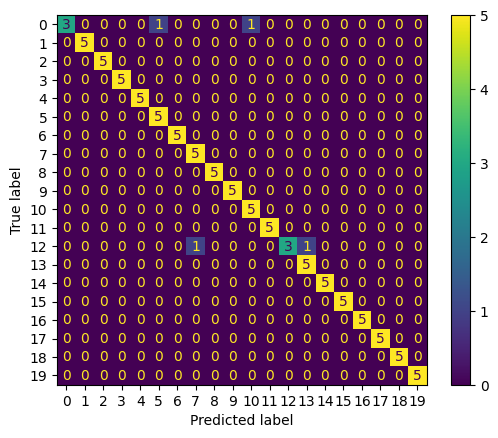

In [27]:
y_pred,y = test_model(model,test_ds)

In [31]:
test_ds.class_names[13]

'ALTAMIRA YELLOWTHROAT'

In [157]:
model.evaluate(test_ds)

100/100 [==============================] - 3s 30ms/step - loss: 0.1708 - accuracy: 0.9600


[0.17080329358577728, 0.9599999785423279]